# Overview of the analysis



# Install requirements
Before, we start, please ensure that you have the below requirements.
You can install them by uncommenting the below code snippet. It is commented on purpose to allow you of a chance to install the requirements using your preferred package managers

In [239]:
# import sys
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install plotly
# !{sys.executable} -m pip install psutil
# !{sys.executable} -m pip install kaleido
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install scipy

# Import python dependencies
Before we do any processing, we need to import all required libraries for python. These are available on PyPi repository

In [238]:
import json
import requests
import pandas as pd
from datetime import datetime
import plotly.express as px
import seaborn as sns
from scipy.stats import ttest_ind
import plotly.graph_objects as go
from scipy import stats

# Question 1
My first question here is, is there a difference in the average score for aggression between the group of people that chose to provide demographics vs those that did not choose to provide demographics

In order to find this, we will first need to separate out these 2 groups

Below code, separates out the 2 groups and prints the shape

# Import data


In [92]:
dataset_name = 'aggression'
dir_name = '4267550'
annotations = pd.read_csv('../{dir_name}/{dataset_name}_annotations.tsv'
                          .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                          header=0)
annotated_comments = pd.read_csv('../{dir_name}/{dataset_name}_annotated_comments.tsv'
                                 .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                 header=0)
worker_demographics = pd.read_csv('../{dir_name}/{dataset_name}_worker_demographics.tsv'
                                             .format(dir_name=dir_name, dataset_name=dataset_name), sep='\t', 
                                             header=0)



# EDA

## Observe the columns
Lets first observe what column each dataset has and can we join on some columns

In [104]:
print(annotations.columns)
print(annotated_comments.columns)
print(worker_demographics.columns)

Index(['rev_id', 'worker_id', 'aggression', 'aggression_score'], dtype='object')
Index(['rev_id', 'comment', 'year', 'logged_in', 'ns', 'sample', 'split'], dtype='object')
Index(['worker_id', 'gender', 'english_first_language', 'age_group',
       'education'],
      dtype='object')


Now, lets check the size of data in these dataframes

In [105]:
print(annotations.shape)
print(annotated_comments.shape)
print(worker_demographics.shape)

(1365217, 4)
(115864, 7)
(2190, 5)


Lets first take a mean of score per worker id. This will allow us to do more EDA and analyze the effect of worker demographics on their scoring

In [102]:
mean_score_per_worker = annotations.groupby("worker_id").mean().reset_index()[['worker_id', dataset_name + '_score']]
mean_score_per_worker.rename(columns={dataset_name + '_score': 'score'}, inplace=True)


In [129]:
mean_score_per_worker.head(3)

,worker_id,score
0,0,-0.461388
1,1,-0.092138
2,2,0.000000


In [137]:
all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


(4053, 7)
(2190, 7)
(1863, 7)


In [138]:
scores_with_no_demographics.head(3)

,worker_id,score,gender,english_first_language,age_group,education,demo_present
1,1,-0.092138,NaN,NaN,NaN,NaN,left_only
2,2,0.000000,NaN,NaN,NaN,NaN,left_only
3,3,-0.050242,NaN,NaN,NaN,NaN,left_only


## Analyzing if there is any difference

Now, since we have the 2 groups, lets try to visually see if we can observe any difference. We shall use a boxplot to observe the difference.

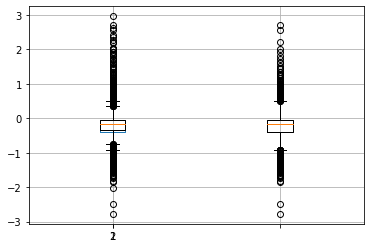

In [156]:
pd.DataFrame(scores_with_no_demographics['score']).boxplot()
plt.boxplot([scores_with_demographics['score'], scores_with_no_demographics['score']])
plt.show()

We do observe some difference but, it would be better to visualize this in a slightly better fashion so that we can also observe the shape of the variance.
Hence, we shall use a violin plot.

In [166]:
fig = go.Figure()

fig.add_trace(go.Violin(y=scores_with_no_demographics['score'],
                        box_visible=True,
                        name='No Demographics',
                        meanline_visible=True))

fig.add_trace(go.Violin(y=scores_with_demographics['score'],
                        box_visible=True,
                        name='With Demographics',
                        meanline_visible=True))
fig.update_layout(autosize=True)
fig.show()

### Observation
The above visual shows that there is a difference but it is not very clear on how much is the difference

Lets print it out for comparison

In [154]:
with_demo_mean = scores_with_demographics['score'].mean()
with_demo_var = scores_with_demographics['score'].var()


no_demo_mean = scores_with_no_demographics['score'].mean()
no_demo_var = scores_with_no_demographics['score'].var()

print('Data with identified demographics has mean = {with_demo_mean} and \
variance={with_demo_var} and Data with no demographics has mean = {no_demo_mean} \
and variance={no_demo_var}'.format(with_demo_mean=with_demo_mean,
                                    with_demo_var=with_demo_var,no_demo_mean=no_demo_mean,
                                    no_demo_var=no_demo_var))

Data with identified demographics has mean = -0.17531208754349292 and variance=0.1353670174426749 and Data with no demographics has mean = -0.22184714196905714 and variance=0.21386974280469004


### Observation
As we see above, the mean are indeed different but we are not yet convinced if this difference is statistically significant.
Hence, we will do a t-test.

## T-Test
### H0 (null hypothesis) - The mean score of the group which has provided demographics is same as the mean score of the group which has not provided demographic information
### H1(alternate hypothesis) - The mean score of the group which has provided demographics is not same as the mean score of the group which has not provided demographic information

In [155]:
ttest,pval = ttest_ind(scores_with_no_demographics['score'],scores_with_demographics['score'])
if pval <0.05:
    print("We reject null hypothesis")
else:
    print("we fail to reject the null hypothesis")

We reject null hypothesis


## Conclusion
There indeed is a statistically significant difference in the mean values of the group that provided demographics vs the group that did not provide demographics.

## Impications on studying the bias in the dataset

The main objective of doing the above work was to study if there is any bias in the dataset.
After doing the above test, we do see an evidence of bias. Specifically, it appears as the group that had strong negative opinion avoided providing the demographic information.

Compared to the group that had slightly less negative opinion on the comments decided to provide their information.

# Question 2
Is there a difference in the average score for toxicity between gender and education level for different workers.

In order to find this, we will use `scores_with_demographics` as it contains `gender` and `education` information.

Let us first observe if these levels for all the workers is equal.
In order to do this, we analyze the counts of these dataframes.
Before this, we will remove the gender=other

In [279]:
dataset_name = 'toxicity'
dir_name = '4563973'
all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


(4053, 7)
(2190, 7)
(1863, 7)


In [280]:

all_scores_by_demographics = mean_score_per_worker.merge(worker_demographics, how='left', on='worker_id', indicator='demo_present')
scores_with_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'both']
scores_with_no_demographics = all_scores_by_demographics[all_scores_by_demographics['demo_present'] == 'left_only']

print(all_scores_by_demographics.shape)
print(scores_with_demographics.shape)
print(scores_with_no_demographics.shape)


scores_with_no_demographics.head(3)

(4053, 7)
(2190, 7)
(1863, 7)


,worker_id,score,gender,english_first_language,age_group,education,demo_present
1,1,-0.092138,NaN,NaN,NaN,NaN,left_only
2,2,0.000000,NaN,NaN,NaN,NaN,left_only
3,3,-0.050242,NaN,NaN,NaN,NaN,left_only


In [281]:
scores_with_demographics = scores_with_demographics[scores_with_demographics['gender'] != 'other']

Next, lets try to see the difference in various levels

In [282]:
gender_education = scores_with_demographics.groupby(['gender', 'education']).count().reset_index()[['gender', 'education', 'worker_id']]
gender_education['count_of_records'] = gender_education['worker_id']
gender_education.head(200)


,gender,education,worker_id,count_of_records
0,female,bachelors,363,363
1,female,doctorate,8,8
2,female,hs,240,240
3,female,masters,148,148
4,female,professional,63,63
5,female,some,18,18
6,male,bachelors,498,498
7,male,doctorate,12,12
8,male,hs,391,391
9,male,masters,237,237


Lets visualize this on a scatter plot to get a better feel for each of these groups

In [231]:
fig = px.scatter(gender_education, x="education", y="gender", color="count_of_records",
                 size='count_of_records', hover_data=['gender', 'education'])
fig.show()

As we observe, the groups are indeed not equal and it seems that males with bachelor degree have much higher representation that female with doctorate degree.

Next one by one, lets try to analyze if there is a difference in the mean score for different groups.

First, lets analyze if there is a difference in the mean score for gender.

In [242]:
fig = px.violin(scores_with_demographics, x="gender", y="score", box = True, points='outliers')
fig.show()

Now, lets see if there is overall difference with the combined groups

In [245]:
fig = px.violin(scores_with_demographics, x="gender", y="score", color='education', 
                box = True, points='outliers')
fig.show()

We do see that there is a difference in the mean scores for all the groups.

It will be however convenient to see both the count of records and mean score on a single chart, this will make it easier for us to compare.
For that, we will first need to get a dataframe with both count and means

In [248]:
gender_education_means = scores_with_demographics.groupby(['gender', 'education']).mean().reset_index()[['gender', 'education', 'score']]
gender_education_means.head(200)


,gender,education,score
0,female,bachelors,-0.208363
1,female,doctorate,-0.105532
2,female,hs,-0.225687
3,female,masters,-0.219272
4,female,professional,-0.244243
5,female,some,-0.187635
6,male,bachelors,-0.134539
7,male,doctorate,-0.086783
8,male,hs,-0.149181
9,male,masters,-0.181565


Next, we shall combine both the dataframes - the one with count and another with mean

In [259]:
score_count = gender_education.merge(gender_education_means, how='inner', on=['gender', 'education'])
score_count[['gender', 'education', 'count_of_records', 'score']]


,gender,education,count_of_records,score
0,female,bachelors,363,-0.208363
1,female,doctorate,8,-0.105532
2,female,hs,240,-0.225687
3,female,masters,148,-0.219272
4,female,professional,63,-0.244243
5,female,some,18,-0.187635
6,male,bachelors,498,-0.134539
7,male,doctorate,12,-0.086783
8,male,hs,391,-0.149181
9,male,masters,237,-0.181565


In [275]:
fig = px.scatter(score_count, x='education', y="score", color='gender',
                 size='count_of_records', hover_data=['gender', 'education'])
fig.show()